In [1]:
rows = 1025
cols = 50

In [2]:
import librosa
import numpy as np
import cv2
import glob

In [3]:
def store_stft_npy(fname):
    y, sr = librosa.load('Audio_Data/ch/'+fname)
    STFT = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    STFT = cv2.resize(STFT.astype('float'), (cols, rows), interpolation = cv2.INTER_CUBIC)
    np.save('ch_stft_npy/'+fname, STFT)
    
filename = glob.glob(r'Audio_Data/ch/*.wav')
for i in range(len(filename)):
    # mac
    # filename[i] = filename[i].split('/')[1]
    # window
    filename[i] = filename[i].split('\\')[1]
    store_stft_npy(filename[i])

In [4]:
# 更新rows和cols
rows = 300
cols = 50

In [5]:
# 讀取npy，總共1500筆
import random
from keras.utils import np_utils
x_list = []
y_list = []
filename_npy = glob.glob(r'ch_stft_npy/*.npy')
random.shuffle(filename_npy)
for i in range(len(filename_npy)):
    ## 砍掉上半
    x_tmp = np.load(filename_npy[i])[:rows,:]
    x_list.append(x_tmp)
    # mac
    # y_list.append(filename_npy[i].split('/')[1][0])
    # window
    y_list.append(filename_npy[i].split('\\')[1][0])

Using TensorFlow backend.


In [6]:
len(x_list)

1500

In [7]:
# 1350做train、150做test
div = 1350
x_train = np.asarray(x_list[:div])
y_train = np.asarray(y_list[:div])
x_test = np.asarray(x_list[div:])
y_test = np.asarray(y_list[div:])

x_train = x_train.reshape(-1,rows,cols,1)
x_test = x_test.reshape(-1,rows,cols,1)

print(x_train.max(), x_train.min())
print(x_test.max(), x_test.min())

# normalized和1-hot
x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

2.51664800356 -86.4408781183
1.80118551419 -85.3839360251


In [8]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# import package
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import SGD
from keras.datasets import mnist
from keras import optimizers
from keras.layers.advanced_activations import LeakyReLU

In [9]:
tf.test.is_gpu_available()

True

In [10]:
#%% model
model = Sequential()

input_shape = (rows, cols, 1)

model.add(Conv2D(16, (7, 7), padding='same', input_shape=input_shape))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(32, (5, 5), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.0005),
              loss='kullback_leibler_divergence',
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 50, 16)       800       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 300, 50, 16)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 25, 16)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 25, 16)       64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 25, 32)       12832     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 150, 25, 32)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 13, 32)        0         
__________

In [12]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping('val_acc', patience=5, verbose=1)

In [13]:
#%% fit model
model_history = model.fit(x_train, y_train, batch_size=128, epochs=100,
                          validation_data = (x_test, y_test),
                          shuffle = True,
                          callbacks=[early_stopping]
                         )

Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 6s 4ms/step - loss: 1.6964 - acc: 0.4667 - val_loss: 1.3090 - val_acc: 0.5867
Epoch 2/100
1350/1350 [==============================] - 2s 1ms/step - loss: 0.4873 - acc: 0.8548 - val_loss: 0.4770 - val_acc: 0.8400
Epoch 3/100
1350/1350 [==============================] - 2s 1ms/step - loss: 0.2288 - acc: 0.9452 - val_loss: 0.3646 - val_acc: 0.8800
Epoch 4/100
1350/1350 [==============================] - 2s 1ms/step - loss: 0.1244 - acc: 0.9726 - val_loss: 0.1294 - val_acc: 0.9467
Epoch 5/100
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0884 - acc: 0.9830 - val_loss: 0.0771 - val_acc: 0.9667
Epoch 6/100
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0579 - acc: 0.9889 - val_loss: 0.0343 - val_acc: 0.9867
Epoch 7/100
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0383 - acc: 0.9963 - val_loss: 0.0211 - val_acc: 0.9867
Epoch 8/

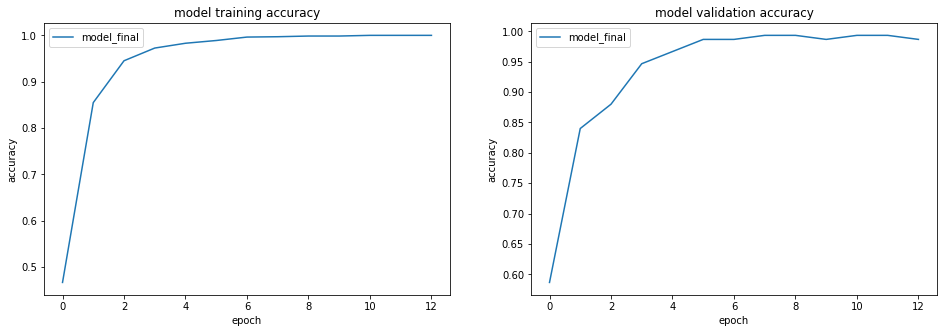

150/150 [==============================] - 1s 3ms/step
Loss: 0.025419
testing accuracy: 98.666668


In [14]:
#%% 作圖
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1,2,1)
plt.plot(model_history.history["acc"])

plt.title("model training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["model_final"], loc = "best")

ax2 = fig.add_subplot(1,2,2)
plt.plot(model_history.history["val_acc"])

plt.title("model validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["model_final"], loc = "best")

plt.show()

#%% score
score = model.evaluate(x_test, y_test, batch_size=10000)
print("Loss: %f" %score[0])
print("testing accuracy: %f" %(score[1]*100))

In [15]:
#%% 儲存model
model.save('CH_STFT_CNN.h5')